This project will utilize a classification model to predict whether or not passengers of the Titanic survived its sinking. I'll be utilizing LogisticRegression from Scikit-Learn for this task.

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold, \
learning_curve, validation_curve, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, \
confusion_matrix, precision_recall_curve, f1_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

First, I'll load in the training dataset for EDA.

In [ ]:
# Load train data
train = pd.DataFrame(pd.read_csv('train.csv'))
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


Null values are already visible in the Cabin column. I'll check the rest for missing entries.

In [ ]:
# Check train for null values
print(train.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


There are null values in 3 columns. Those will need to be dealt with first before moving on. Starting with the Age column, I'll visualize the distribution to see if the data is normally distributed.

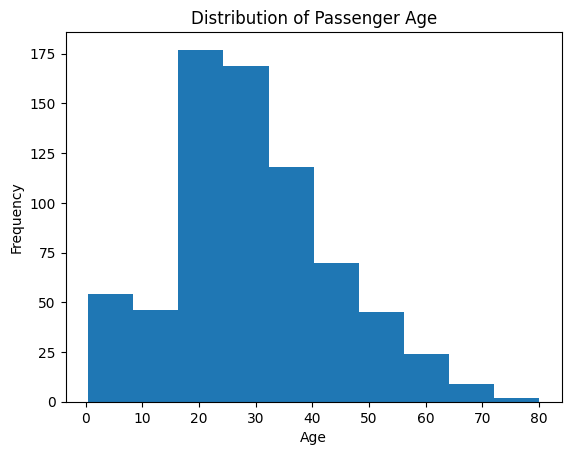

In [ ]:
# Plot distribution of Age column
plt.hist(train.Age)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Passenger Age')
plt.show()

The distribution is skewed right, so I'll use the median of ages to populate null values to account for extremes.

In [ ]:
# Fill null values with median age
train.Age = train.Age.fillna(train.Age.median())

Now to view the Cabin column.

In [ ]:
# View non-null Cabin values
print(train.loc[train.Cabin.notna(), 'Cabin'].head(10))

1             C85
3            C123
6             E46
10             G6
11           C103
21            D56
23             A6
27    C23 C25 C27
31            B78
52            D33
Name: Cabin, dtype: object


Currently, the column values are not of much use as features because they are too unique and numerous. I'm going to try and convert them into something more workable. The Titanic's cabin designations are formatted with a letter indicating the deck level followed by a cabin number. For the model, I'll isolate the deck levels and use them as features, designating missing values as 'Unknown'.



In [ ]:
# Isolate deck level from Cabin designations
train.Cabin = train.Cabin.str.replace(r'\d+', '', regex=True)

# Remove duplicate designations
train.Cabin = train.Cabin.str.extract(r'([A-Z])$', expand=False)

# Fill null values in Cabin column with 'Unknown'
train.Cabin = train.Cabin.fillna('Unknown')

# Rename Cabin column: Deck
train = train.rename(columns={'Cabin': 'Deck'})

# Replace 'T' deck with 'Unknown'
train.Deck = train.Deck.str.replace('T', 'Unknown')

# View decks
print(f'Decks: {train.Deck.unique()}')

Decks: ['Unknown' 'C' 'E' 'G' 'D' 'A' 'B' 'F']


Now that the deck levels have been isolated, because there was such a large number of initial cabin entries that were missing, I'll check the distribution grouped by ticket class.

In [ ]:
# View distribution of Deck levels by ticket class
print(train.groupby('Pclass')['Deck'].value_counts())

Pclass  Deck   
1       C           59
        B           47
        Unknown     41
        D           29
        E           25
        A           15
2       Unknown    168
        F            8
        D            4
        E            4
3       Unknown    479
        G            7
        E            4
        F            1
Name: count, dtype: int64


There's a lot of missing values for 2nd and 3rd-class passengers! Unfortunately, due to the amount of missing data, the Deck levels will be of no value to the model. Because passenger IDs, names, ticket numbers, fare amounts, and port of embarkment will likely not help to predict survival, these columns can be safely removed as well. I'll also convert all catergorical columns to the proper data type.

In [ ]:
# Drop unnecesary columns
train = train.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Embarked',
                    'Deck'], axis=1)

# Convert categorical columns' dtype
train[['Pclass', 'Sex']] = train[['Pclass', 'Sex']].astype('category')

# View cleaned train data
print(train.head())

   Survived Pclass     Sex   Age  SibSp  Parch
0         0      3    male  22.0      1      0
1         1      1  female  38.0      1      0
2         1      3  female  26.0      0      0
3         1      1  female  35.0      1      0
4         0      3    male  35.0      0      0


Before I begin building a model, I'll check the class weights of Survived -- the target variable -- in the training data.

In [ ]:
# View target class weights
print(train.Survived.value_counts(normalize=True))

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


Due to the imbalance in the class weights and binary nature of our target variable, I'll build a base model with class weight and solver method hyperparameters set. I'll also plot feature coefficients to compare later after model tuning.

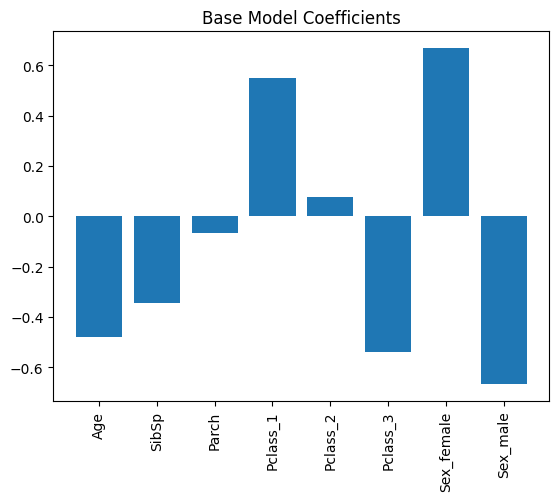

In [ ]:
# Create a dictionary of class weights
class_weights = {0: 0.616, 1: 0.384}

# Create model variables
X = pd.get_dummies(train.drop('Survived', axis=1)).values
y = pd.get_dummies(train.Survived).iloc[:, 1].values

# Create scaler
scaler = StandardScaler()

# Scale X features
X_scaled = scaler.fit_transform(X)

# Instantiate classification model: logreg
logreg = LogisticRegression(class_weight=class_weights, solver='liblinear',
                            random_state=206)

# Fit model
logreg.fit(X_scaled, y)

# Plot model coefficients
names = pd.get_dummies(train.drop('Survived', axis=1)).columns
logreg_coefs = logreg.coef_.flatten()
plt.bar(names, logreg_coefs)
plt.xticks(rotation=90)
plt.title('Base Model Coefficients')
plt.show()

It appears that the sex of the passengers affect survival rates significantly, with women having a much higher likelihood of survival. The age of passengers is also negatively correlated with their odds of survival -- younger passengers were much more likely to survive. Whether or not passengers have siblings or spouses aboard also notably contributes to survival, those with spouse/siblings having lower survival odds. The ticket class of passengers also noticeably contributes to survival rates. The higher one's class the higher the odds of survival.

Now I will run cross-validation on the model optimizing based on f1-score for a balance of precision and recall. I'll be using a stratified KFold method to account for class imbalance.

In [ ]:
# Create a parameter grid for cross-validation
param_grid = {
    'penalty': ['l1', 'l2'],
    'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False]
}

# Create KFold object
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=206)

# Run cross-validation
logreg_cv = GridSearchCV(logreg, param_grid, cv=kf, scoring='f1')
logreg_cv.fit(X_scaled, y)
print(logreg_cv.best_params_)

{'C': 10, 'fit_intercept': False, 'penalty': 'l1', 'tol': 0.001}


Using the discovered best parameters, I'll instantiate a tuned model and check feature coefficients against the base model for changes.

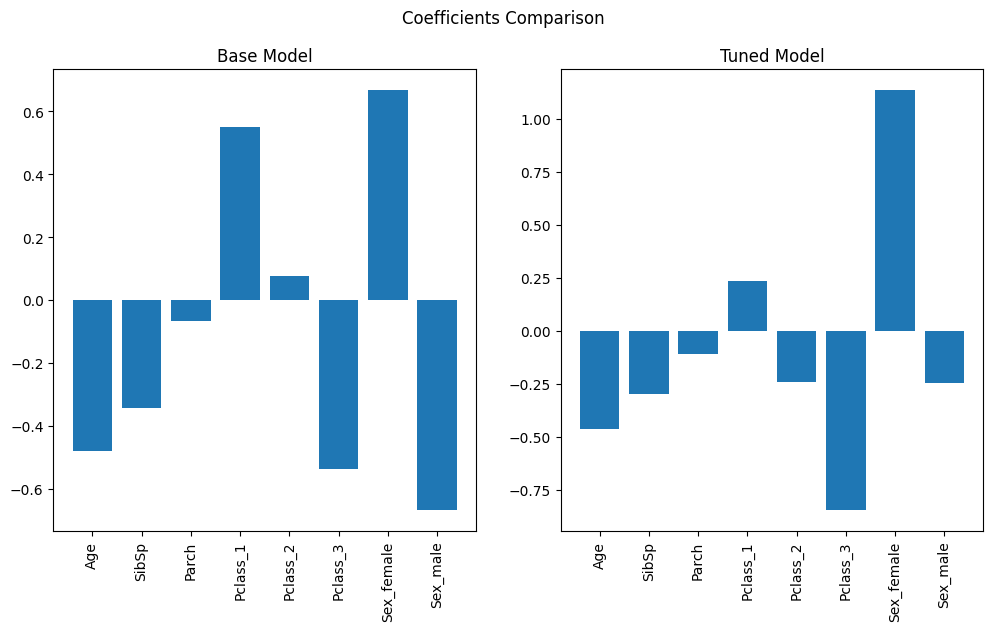

In [ ]:
# Instantiate tuned model
logreg_t = LogisticRegression(penalty='l1', tol=1e-3, C=10,
                                  fit_intercept=False,
                                  class_weight=class_weights,
                                  solver='liblinear',
                                  random_state=206)

# Fit tuned model
logreg_t.fit(X_scaled, y)

# Plot coefficients
logreg_t_coefs = logreg_t.coef_.flatten()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Coefficients Comparison')
ax1.bar(names, logreg_coefs)
ax1.set_title('Base Model')
ax1.set_xticks(np.arange(len(names)))
ax1.set_xticklabels(names, rotation=90)
ax2.bar(names, logreg_t_coefs)
ax2.set_title('Tuned Model')
ax2.set_xticks(np.arange(len(names)))
ax2.set_xticklabels(names, rotation=90)
plt.show()

The tuned model has become more sensitive to gender and passenger class. This could potentially improve the model's performance. I will now evaluate both models' learning curves to assess fit.

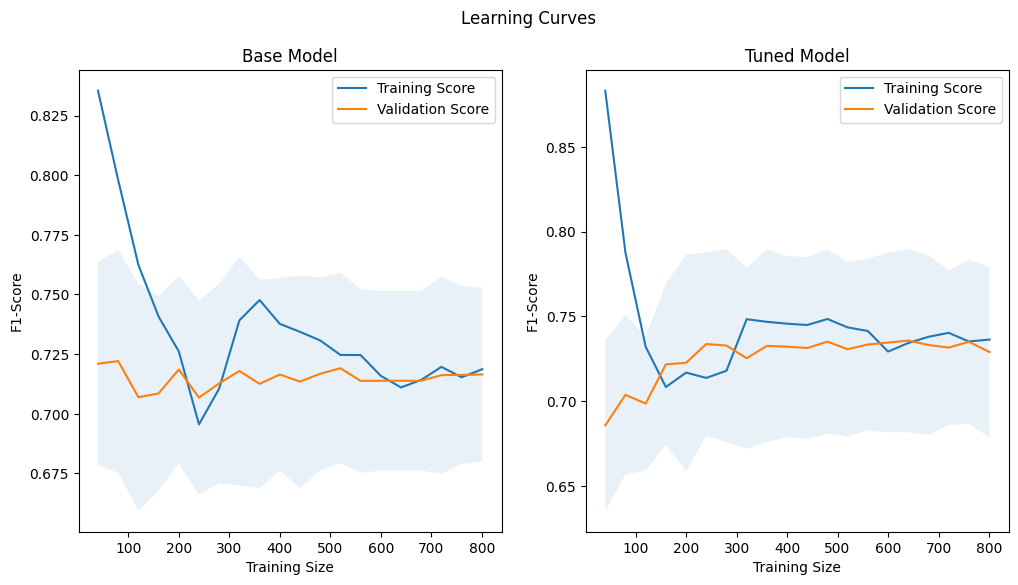

In [ ]:
# Learning curve variables
train_sizes_b, train_scores_b, val_scores_b = \
  learning_curve(logreg, X_scaled, y, cv=kf, scoring='f1',
                 train_sizes=np.linspace(0.05, 1, 20))
train_sizes_t, train_scores_t, val_scores_t = \
  learning_curve(logreg_t, X_scaled, y, cv=kf, scoring='f1',
                 train_sizes=np.linspace(0.05, 1, 20))

# Calculate mean and std of scores
train_mean_b = train_scores_b.mean(axis=1)
train_mean_t = train_scores_t.mean(axis=1)
train_std_b = train_scores_b.std(axis=1)
train_std_t = train_scores_t.std(axis=1)
val_mean_b = val_scores_b.mean(axis=1)
val_mean_t = val_scores_t.mean(axis=1)
val_std_b = val_scores_b.std(axis=1)
val_std_t = val_scores_t.std(axis=1)

# Plot learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Learning Curves')
ax1.plot(train_sizes_b, train_mean_b, label='Training Score')
ax1.plot(train_sizes_b, val_mean_b, label='Validation Score')
ax1.fill_between(train_sizes_b, val_mean_b - val_std_b, val_mean_b + val_std_b,
                 alpha=0.1)
ax1.set_xlabel('Training Size')
ax1.set_ylabel('F1-Score')
ax1.set_title('Base Model')
ax1.legend()
ax2.plot(train_sizes_t, train_mean_t, label='Training Score')
ax2.plot(train_sizes_t, val_mean_t, label='Validation Score')
ax2.fill_between(train_sizes_t, val_mean_t - val_std_t, val_mean_t + val_std_t,
                 alpha=0.1)
ax2.set_xlabel('Training Size')
ax2.set_ylabel('F1-Score')
ax2.set_title('Tuned Model')
ax2.legend()
plt.show()

The learning curve shows that the tuned model fits slightly better to the data, though there is a large degree of variance. I'll now split the data to run a prediction. I'll evaluate the confusion matrix and classification report.

In [ ]:
# Split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1,
                                                    stratify=y,
                                                    random_state=206)

# Refit model
logreg_t.fit(X_train, y_train)

# Predictions
y_pred = logreg_t.predict(X_test)

# Calculate confusion matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(f'Confusion Matrix:', '\n', cm, '\n',
      'Classification Report:', '\n', cr)

Confusion Matrix: 
 [[44 11]
 [ 8 27]] 
 Classification Report: 
               precision    recall  f1-score   support

       False       0.85      0.80      0.82        55
        True       0.71      0.77      0.74        35

    accuracy                           0.79        90
   macro avg       0.78      0.79      0.78        90
weighted avg       0.79      0.79      0.79        90



The confusion matrix and classification report indicate that the model is performing pretty well overall but I'd like to address the variance seen in the learning curve. To do this I'll try to supplement the minority class (1) using the SMOTE method. Here I'll isolate the synthetic observations attained from SMOTE and use PCA to plot the synthetic data against the original data. This will help confirm that the synthetic data properly represents the actual dataset.

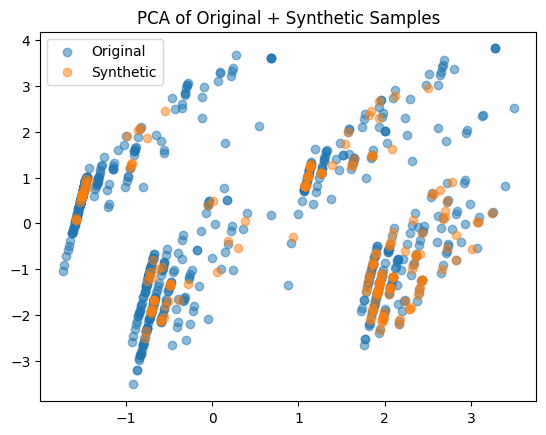

In [ ]:
# Resample with SMOTE
smote = SMOTE(random_state=206)
X_smote, y_smote = smote.fit_resample(X_scaled, y)

# Extract synthetic observations from the X_smote, y_smote
synthetic_X = X_smote[len(X_scaled):]
synthetic_y = y_smote[len(y):]

# Create DataFrames to plot
X_scaled_df = pd.DataFrame(X_scaled, columns=names)
X_synthetic_df = pd.DataFrame(synthetic_X, columns=names)
y_df = pd.Series(y)
y_synthetic_df = pd.Series(synthetic_y)

# Perform PCA
pca = PCA(n_components=2)
X_pca_original = pca.fit_transform(X_scaled_df)
X_pca_synthetic = pca.transform(X_synthetic_df)

# Create DataFrames for PCAs
pca_original_df = pd.DataFrame(X_pca_original, columns=['PC1', 'PC2'])
pca_synthetic_df = pd.DataFrame(X_pca_synthetic, columns=['PC1', 'PC2'])

# Plot PCAs
plt.scatter(pca_original_df['PC1'], pca_original_df['PC2'], label='Original',
            alpha=0.5)
plt.scatter(pca_synthetic_df['PC1'], pca_synthetic_df['PC2'], label='Synthetic',
            alpha=0.5)
plt.title('PCA of Original + Synthetic Samples')
plt.legend()
plt.show()

The generated observations seem to fit well with the orginal dataset. I want to now rerun cross-validation on my model fitted with the synthetic dataset to see if there are any increases in performance from the generated observations. First, I'll ensure the target classes are balanced.

In [ ]:
# Create new DataFrame for y_smote
y_smote_df = pd.DataFrame(y_smote).astype('int')
print(y_smote_df.value_counts(normalize=True))

0    0.5
1    0.5
Name: proportion, dtype: float64


The classes are balanced, so I'll now run cross validation again for them model. This time I'll prioritize accuracy in the scoring method since I'm now working with balanced classes.

In [ ]:
# Instantiate new LogisticRegression without class weights: reg
logreg_s = LogisticRegression(solver='liblinear', random_state=206)

# Rerun cross-validation with the new data
logreg_s_cv = GridSearchCV(logreg_s, param_grid, cv=kf, scoring='accuracy')
logreg_s_cv.fit(X_smote, y_smote)
print(logreg_s_cv.best_params_)

{'C': 100, 'fit_intercept': True, 'penalty': 'l1', 'tol': 0.0001}


Some of the optimal hyperparameters have changed. I'll instantiate a new model with these results and plot its learning curve.

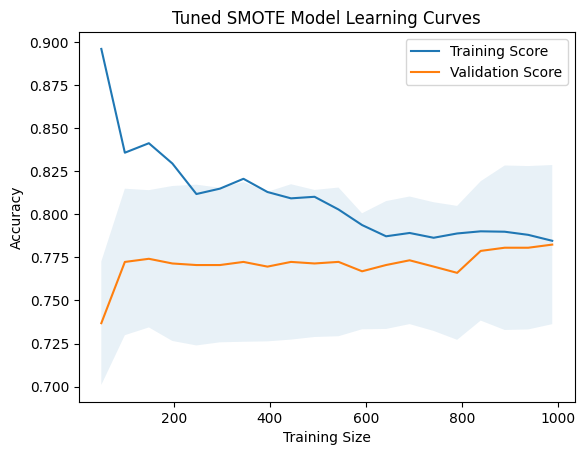

In [ ]:
# Instantiate new tuned model
logreg_s_t = LogisticRegression(penalty='l1', tol=1e-4, C=100,
                                solver='liblinear', random_state=206)

# Fit new model
logreg_s_t.fit(X_smote, y_smote)

# New learning curve variables
train_sizes_s, train_scores_s, val_scores_s = \
  learning_curve(logreg_s_t, X_smote, y_smote, cv=kf, scoring='accuracy',
                 train_sizes=np.linspace(0.05, 1, 20))

# Calculate mean and std of new scores
train_mean_s = train_scores_s.mean(axis=1)
train_std_s = train_scores_s.std(axis=1)
val_mean_s = val_scores_s.mean(axis=1)
val_std_s = val_scores_s.std(axis=1)

# Plot new model against old model
plt.plot(train_sizes_s, train_mean_s, label='Training Score')
plt.plot(train_sizes_s, val_mean_s, label='Validation Score')
plt.fill_between(train_sizes_s, val_mean_s - val_std_s, val_mean_s + val_std_s,
                 alpha=0.1)
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Tuned SMOTE Model Learning Curves')
plt.legend()
plt.show()

The learning curve suggests the model may be overfitting due to the gap between training and validation.
I'll now split the data and run predictions to evaluate the confusion matrix and classification report for the new model.

In [ ]:
# Split data
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_smote, y_smote,
                                                    test_size=0.1,
                                                    random_state=206)

# Refit model
logreg_s_t.fit(X_train_s, y_train_s)

# Predictions
y_pred_s = logreg_s_t.predict(X_test_s)

# Calculate confusion matrix, classification_report
cm_s = confusion_matrix(y_test_s, y_pred_s)
cr_s = classification_report(y_test_s, y_pred_s)
print(f'Confusion Matrix:', '\n', cm_s, '\n',
      'Classification Report:', '\n', cr_s)

Confusion Matrix: 
 [[38 13]
 [13 46]] 
 Classification Report: 
               precision    recall  f1-score   support

       False       0.75      0.75      0.75        51
        True       0.78      0.78      0.78        59

    accuracy                           0.76       110
   macro avg       0.76      0.76      0.76       110
weighted avg       0.76      0.76      0.76       110



The SMOTE model doesn't seem to have improved the overall performance of the model, so I will return to using the previous one. It's possible that my overall model performance could be improved by using other models or ensemble methods, but for the purposes of this project I will only be using the LogisticRegression model.

I'll now plot a precision-recall curve to help evaluate a best threshold for my model.

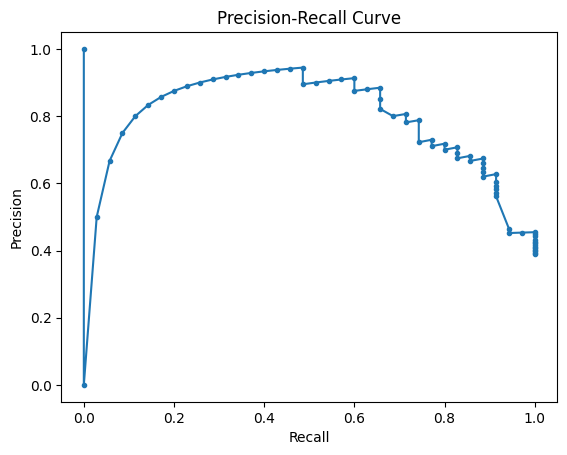

In [ ]:
# Prediction probabilities
y_pred_prob = logreg_t.predict_proba(X_test)[:, 1]

# Plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

The AUC is a great sign for the model's performance, and it appears that precision starts to really drop off around a recall of 0.6.
I'll now isolate the best threshold for f1-score to use in the final predictions.

In [ ]:
# Get best threshold
for threshold in thresholds:
  y_pred = (y_pred_prob >= threshold).astype('int')
  f1 = f1_score(y_test, y_pred)
  if f1 > best_f1:
    best_f1 = f1
    best_threshold = threshold
print(f'Best threshold: {best_threshold}')

Best threshold: 0.52


With the best threshold isolated, I'll now create a new confusion matrix and classification report.

In [ ]:
# Repredict y_pred for confusion matrix
y_pred = (y_pred_prob >= best_threshold).astype('int')

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(f'Confusion Matrix:', '\n', cm)

Confusion Matrix: 
 [[45 10]
 [ 8 27]]


The confusion matrix utilizing optimal threshold setting resulted in a very similar confusion matrix as before. This makes sense due to the plateauing of the tuned model's validation curve.

Now I'll load in the Titanic test data for final predictions.

In [ ]:
# Load in test data
test = pd.DataFrame(pd.read_csv('test.csv'))
print(test.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


I'll need to clean it up as I did the train data before in order to fit it to the model.

In [ ]:
# Check for null values
print(test.isna().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [ ]:
# Fill nulls with median age
test.Age = test.Age.fillna(test.Age.median())

# Drop unnecessary columns
test_clean = test.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin',
                        'Embarked'], axis=1)

# Convert categorical columns' dtype
test_clean[['Pclass', 'Sex']] = test_clean[['Pclass', 'Sex']].astype('category')

# View cleaned test data
print(test_clean.head())

  Pclass     Sex   Age  SibSp  Parch
0      3    male  34.5      0      0
1      3  female  47.0      1      0
2      2    male  62.0      0      0
3      3    male  27.0      0      0
4      3  female  22.0      1      1


In [ ]:
# Create dummy variables
test_dummies = pd.get_dummies(test_clean).values

# Scale test data
test_clean_scaled = scaler.transform(test_dummies)

# Predict target variables
test_pred_prob = logreg_t.predict_proba(test_clean_scaled)[:, 1]
test_pred = (test_pred_prob >= best_threshold).astype('int')

# Create DataFrame for submission
predictions = pd.DataFrame({
    'PassengerId': test.PassengerId,
    'Survived': test_pred
})
print(predictions)

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


Now to export the DataFrame.

In [ ]:
# Export predictions DataFrame
predictions.to_csv('predictions.csv', index=False)